## Test component-wise spline normalizing flow

This module transforms base distribution N(0,1) to an arbitrary non-gaussian prior.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ltcl
import torch
from ltcl.modules.components.transforms import ComponentWiseSpline

In [3]:
from ltcl.modules import components

In [4]:
import torch.distributions as D
import torch.nn as nn

In [11]:
class Flow(nn.Module):
    def __init__(self, transforms, input_size=2):
        super().__init__()
        self.net = transforms
        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(input_size))
        self.register_buffer('base_dist_var', torch.eye(input_size))

    @property
    def base_dist(self):
        return D.MultivariateNormal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x):
        return self.net(x)

    def inverse(self, z):
        return self.net.inverse(z)

    def log_prob(self, x):
        z, sum_log_abs_det_jacobians = self.forward(x)
        logp = self.base_dist.log_prob(z) + sum_log_abs_det_jacobians
        print(logp.shape)
        return torch.mean(logp)

    def sample(self, batch_size): 
        z = self.base_dist.sample((batch_size, ))
        logp = self.base_dist.log_prob(z)
        x, _ = self.inverse(z)
        return x

### Dataset

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

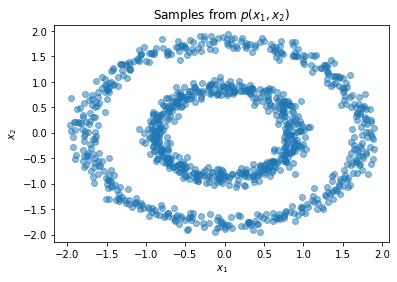

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


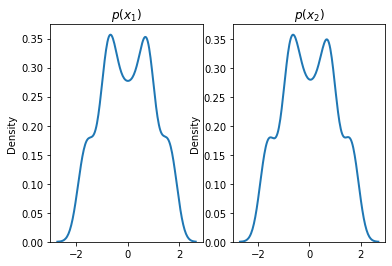

In [7]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import seaborn as sns

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

### Model

In [8]:
flow = Flow(ComponentWiseSpline(2), 2)
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(flow.net.parameters(), lr=1e-2)

In [12]:
for step in range(500):
    optimizer.zero_grad()
    loss = -flow.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()

torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([

torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


torch.Size([1000, 2])


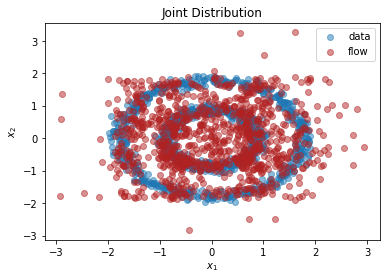

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

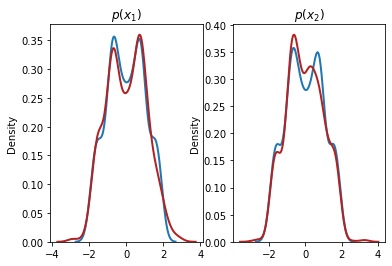

In [13]:
X_flow = flow.sample(1000).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

### Uniform distribution

In [10]:
import numpy as np

In [28]:
n = 1000

In [29]:
X = np.zeros((n,2))

In [30]:
X[:,0] = np.random.uniform(-1,1,n)
X[:,1] = np.random.uniform(-1,1,n)

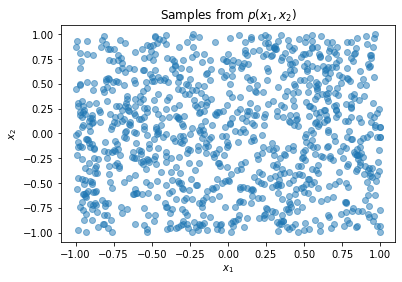

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


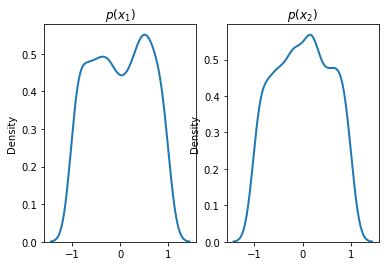

In [31]:
plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

In [83]:
flow = Flow(ComponentWiseSpline(2, 8, 2), 2)
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(flow.net.parameters(), lr=1e-2)

In [84]:
for step in range(1000):
    optimizer.zero_grad()
    loss = -flow.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()

torch.Size([1000, 2])


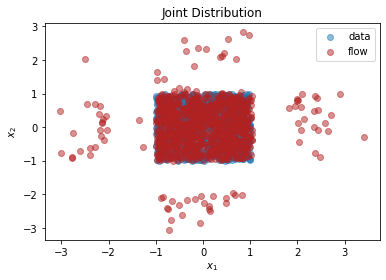

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

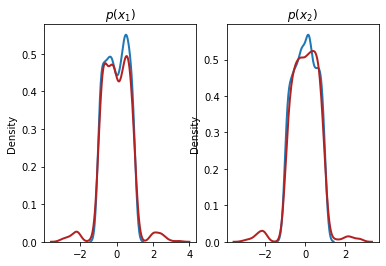

In [85]:
X_flow = flow.sample(1000).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()